In [1]:
import numpy as np
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
import matplotlib.pyplot as plt
from utils import get_mesh_vtk
from utils import get_data
from utils import strip_cross, reconstruct_cross
from KPCA import *
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
import torch
import torch.nn as nn
from utils import calc_energy, torch2np
import glob
import os
# from importlib import reload

In [ ]:
def read_from_ds(Wi, beta, ds_path=None):
    if ds_path is None:
        ds_path = '../npz_data/crossTurb_train'

    files = glob.glob(f'*Wi{Wi:g}_beta{beta:g}*.pt', root_dir=ds_path)
    X = torch.load(f'{ds_path}/{files[0]}')['tensor']
    data = torch.zeros([len(files)] + [s for s in X.shape])
    for i,file in enumerate(files):
        data[i] = torch.load(f'{ds_path}/{file}')['tensor']
    return data

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [2]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [3]:
# Read the meshgrid for computing the energy

vtk_file = '../npz_data/Dados-N0.vtk'
x, y = get_mesh_vtk(vtk_file)
cut = 13 # removes the influence of inflow/outflow
dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
DX, DY = np.meshgrid(dx,dy)
DX = strip_cross(DX[...,None,None], cut).squeeze()
DY = strip_cross(DY[...,None,None], cut).squeeze()

xc = (x[1:] + x[:-1])/2
yc = (y[1:] + y[:-1])/2
X_mesh, Y_mesh = np.meshgrid(xc,yc)
X_mesh = strip_cross(X_mesh[...,None,None], cut).squeeze()
Y_mesh = strip_cross(Y_mesh[...,None,None], cut).squeeze()

In [ ]:
# NN part
small = True # Use less parameter in the architechture

latent_dim = 3
autoencoder = Autoencoder.ParametricVAEModule(n_input= DX.shape[0], latent_dim = latent_dim, max_in=torch.zeros((1,5,1)), min_in=torch.zeros((1,5,1)), small = small).to(device)
if small:
    autoencoder.load_state_dict(torch.load(f'../Models/VAE_CrossParametric_Latent_{latent_dim}_small/best_autoencoder',map_location=torch.device('cpu')))
else:
    autoencoder.load_state_dict(torch.load(f'../Models/VAE_CrossParametric_Latent_{latent_dim}/best_autoencoder',map_location=torch.device('cpu')))

print(get_n_params(autoencoder))

In [5]:

# Parameters:
parameters = [
        (0.8, 0.11111), # Outlier
        (2.5, 0.11111), # 1
        (2.5, 0.22222), # 2
        (2.5, 0.33333), # 3
        (2.5, 0.44444), # 4
        (3.0, 0.11111), # 5
        (3.0, 0.22222), # 6
        (3.5, 0.11111), # 7
        (3.5, 0.22222), # 8
        (3.5, 0.33333), # 9
        (4.0, 0.33333), # 10
        (4.5, 0.11111), # 11
        (4.5, 0.22222), # 12
        (4.5, 0.33333), # 13
        (5.0, 0.11111), # 14
        (5.0, 0.22222), # 15
        (5.0, 0.33333), # 16
        (5.5, 0.11111), # 17
        (5.5, 0.33333), # 18
        (6.0, 0.22222), # 19
        (6.0, 0.44444), # 20
        (6.5, 0.11111), # 21
        (6.5, 0.33333), # 22
        (7.0, 0.11111), # 23
        (7.0, 0.22222), # 24
        (7.0, 0.44444), # 25
        (7.5, 0.11111), # 26
        # test
        (4.0, 0.22222), # -2 (27)
        (7.5, 0.33333)  # -1 (28)
]


In [7]:
## Data reading
ind = -1
Wi ,beta = parameters[ind]
Re = 0.01
params = [Wi, beta]

X_torch = read_from_ds(*params, ds_path='../npz_data/crossTurb_test')
X = torch2np(X_torch)
param = torch.ones((X_torch.shape[0], 2)).float()
param[:] = torch.Tensor(params).float()
print('Data shape: ',X.shape)

Data shape:  (66045, 999)


In [184]:
# Run test
with torch.no_grad():
    _, code, _ = autoencoder.encode(X_torch, param)
    X_ae_torch= autoencoder.decode(code, param)
    # X_ae_torch,_,_ = autoencoder(X_torch.float(), param.float())
X_ae = torch2np(X_ae_torch)

In [185]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = DX[:,None], dy = DY[:,None])

# # Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

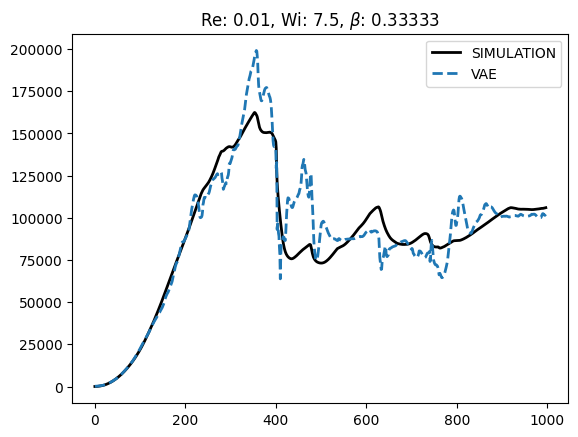

In [186]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

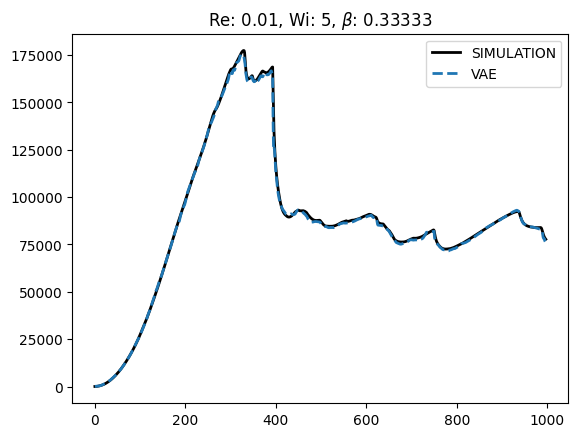

In [76]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

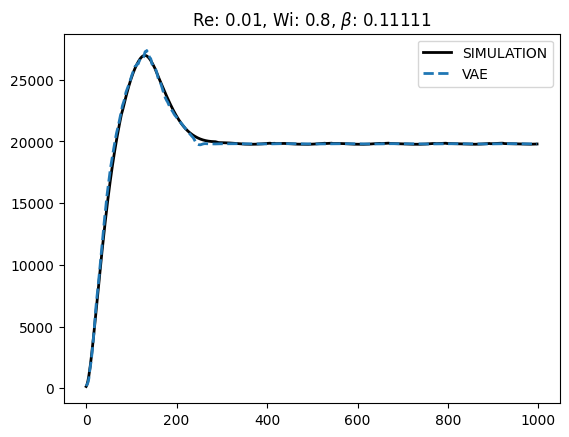

In [29]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

In [41]:


get_n_params(autoencoder)

56397127

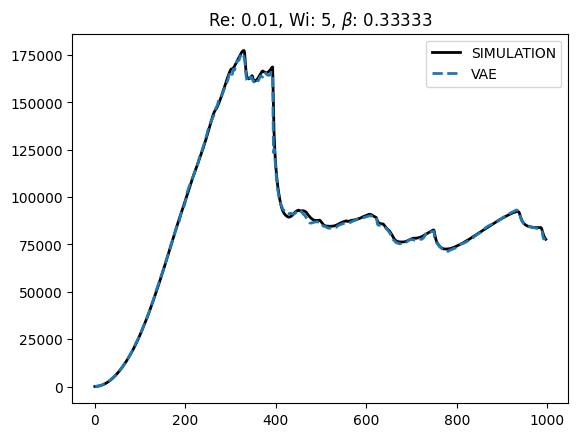

In [40]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

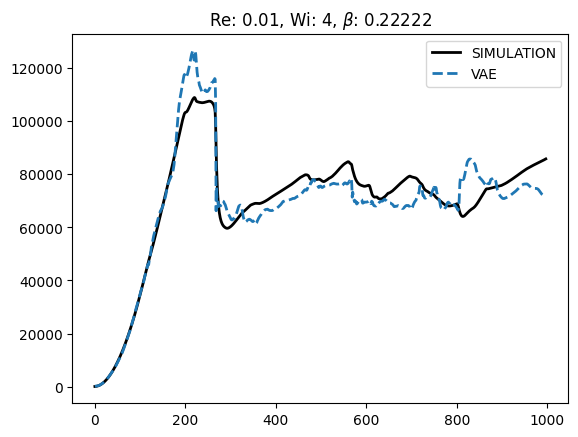

In [182]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

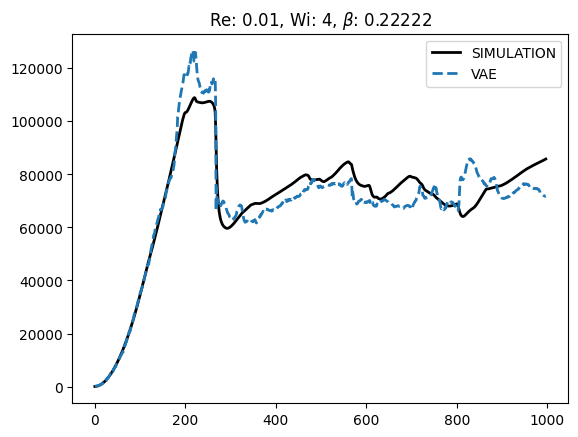

In [18]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

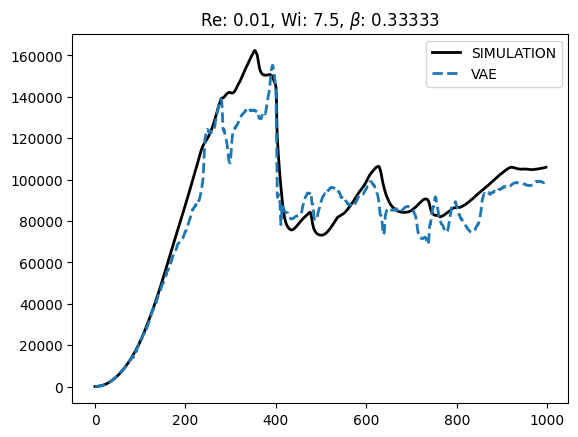

In [92]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

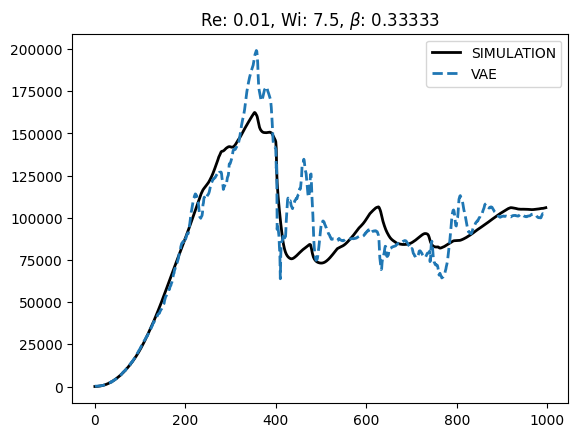

In [10]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

In [135]:
X_ae.shape[0]/5

13209.0

In [180]:
## Visual Plots
X_rec = reconstruct_cross(X_ae.reshape((-1,5,999)), cut)
X_rec[:65-cut,:65-cut] = np.NaN
X_rec[-65+cut:,:65-cut] = np.NaN
X_rec[:65-cut,-65+cut:] = np.NaN
X_rec[-65+cut:,-65+cut:] = np.NaN

X_true = reconstruct_cross(X.reshape((-1,5,999)), cut)
X_true[:65-cut,:65-cut] = np.NaN
X_true[-65+cut:,:65-cut] = np.NaN
X_true[:65-cut,-65+cut:] = np.NaN
X_true[-65+cut:,-65+cut:] = np.NaN

tra_Ar = X_rec[...,2,:]**2 + X_rec[...,4,:]**2 + 2* X_rec[...,3,:]**2
tra_At = X_true[...,2,:]**2 + X_true[...,4,:]**2 + 2* X_true[...,3,:]**2

In [136]:
Xr_mesh = reconstruct_cross(X_mesh[:,None, None], cut).squeeze()
Yr_mesh = reconstruct_cross(Y_mesh[:,None, None], cut).squeeze()

Xr_mesh[:65-cut,:65-cut] = 11
Xr_mesh[-65+cut:,:65-cut] = 11
Xr_mesh[:65-cut,-65+cut:] = 11
Xr_mesh[-65+cut:,-65+cut:] = 11

Yr_mesh[:65-cut,:65-cut] = 11
Yr_mesh[-65+cut:,:65-cut] = 11
Yr_mesh[:65-cut,-65+cut:] = 11
Yr_mesh[-65+cut:,-65+cut:] = 11

In [170]:
np.nanmin(tra_At), np.nanmin(tra_Ar)
np.nanmax(tra_At), np.nanmax(tra_Ar)

(30571.429354816224, 43401.34424339918)

In [181]:
save_dir = f'Images/VAE_parametric_small/Wi_{Wi:g}_beta_{beta:g}'
os.makedirs(save_dir, exist_ok= True)
for t in range(X.shape[1]):
# for t in range(1):
    vmin = np.minimum(np.nanmin(tra_At[...,t]), np.nanmin(tra_Ar[...,t]))
    vmax = np.maximum(np.nanmax(tra_At[...,t]), np.nanmax(tra_Ar[...,t]))
    levels = np.linspace(vmin, vmax, 50)
    f, ax = plt.subplots(1,2, figsize = (10,7))

    ax[0].contourf(Xr_mesh,Yr_mesh,tra_At[...,t], levels=levels)
    ax[0].set_title('Simulation')
    surf = ax[1].contourf(Xr_mesh,Yr_mesh,tra_Ar[...,t], levels=levels)
    ax[1].set_title('VAE')
    plt.colorbar(surf, ax = ax, location='bottom')
    f.suptitle(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}\nt = {t*4e-2:g}')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    f.savefig(f'{save_dir}/frame_{t}.png')
    plt.close()
    